In [1]:
import pandas as pd
import numpy as np
import keras_nlp
from keras_nlp.layers import TokenAndPositionEmbedding

path = "/kaggle/input/movielens1mwithstoryline/"
movies = pd.read_csv(path+ 'ml-1m/movies.dat', sep='::', engine='python', header=None,
                       names=['MovieID', 'title', 'genre'])
movies.head()

2024-05-15 18:29:48.342073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 18:29:48.342236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 18:29:48.505722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,MovieID,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Loading movies description : Storyline

In [2]:
description = pd.read_csv(path+ 'ml-1m/ml_plot.dat', sep='::', engine='python', header=None,
                       names=['movieID', 'plot'])
description.head()

,movieID,plot
0,1,a\tlittle\tboy\tname\tandy\tlove\tto\tbe\tin\t...
1,2,after\tbe\ttrap\tin\ta\tjungle\tboard\tgame\tf...
2,3,thing\tdo\tnot\tseem\tto\tchange\tmuch\tin\twa...
3,4,this\tstory\tbase\ton\tthe\tbest\tselling\tnov...
4,5,in\tthis\tsequel\tto\tfather\tof\tthe\tbride\t...


In [3]:
def replace_tabs(text):
    return text.replace("\t", " ")

# Apply the function to the "description" column
description['plot'] = description['plot'].apply(replace_tabs)
description.head(10)

,movieID,plot
0,1,a little boy name andy love to be in he room p...
1,2,after be trap in a jungle board game for 26 ye...
2,3,thing do not seem to change much in wabasha co...
3,4,this story base on the best selling novel by t...
4,5,in this sequel to father of the bride george b...
5,6,hunter and they prey neil and he professional ...
6,7,while she be grow up sabrina fairchild spend m...
7,8,a mischievous young boy tom sawyer jonathan ta...
8,9,some terrorist kidnap the vice president of th...
9,10,when a deadly satellite weapon system fall int...


## **merge movies and plot with the movieId column**

In [4]:
moviesWP = movies.merge(description, how='inner', left_on='MovieID', right_on='movieID')
moviesWP.head()

,MovieID,title,genre,movieID,plot
0,1,Toy Story (1995),Animation|Children's|Comedy,1,a little boy name andy love to be in he room p...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,2,after be trap in a jungle board game for 26 ye...
2,3,Grumpier Old Men (1995),Comedy|Romance,3,thing do not seem to change much in wabasha co...
3,4,Waiting to Exhale (1995),Comedy|Drama,4,this story base on the best selling novel by t...
4,5,Father of the Bride Part II (1995),Comedy,5,in this sequel to father of the bride george b...


In [5]:
moviesWP.shape

(3675, 5)

In [6]:
moviesWP[moviesWP["MovieID"] > 3675].shape

(264, 5)

In [7]:
moviesWP = moviesWP.drop('movieID',axis=1)
moviesWP.head()

,MovieID,title,genre,plot
0,1,Toy Story (1995),Animation|Children's|Comedy,a little boy name andy love to be in he room p...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,after be trap in a jungle board game for 26 ye...
2,3,Grumpier Old Men (1995),Comedy|Romance,thing do not seem to change much in wabasha co...
3,4,Waiting to Exhale (1995),Comedy|Drama,this story base on the best selling novel by t...
4,5,Father of the Bride Part II (1995),Comedy,in this sequel to father of the bride george b...


## Load and preprocess user information

In [8]:
users_df = pd.read_csv(path+'ml-1m/users.dat', sep='::', engine='python', header=None,
                       names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
users_df['Gender'] = users_df['Gender'].map({'M': 0, 'F': 1})
users_df['Age'] = users_df['Age'].astype(int)

In [9]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,1,1,10,48067
1,2,0,56,16,70072
2,3,0,25,15,55117
3,4,0,45,7,02460
4,5,0,25,20,55455


In [10]:
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic educator", 2: "artist", 3: "clerical admin",
                4: "college grad student", 5: "customer service", 6: "doctor health care",
                7: "executive managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales marketing", 15: "scientist", 16: "self-employed",
                17: "technician engineer", 18: "tradesman craftsman", 19: "unemployed", 20: "writer" }

gender= {0: 'male', 1: 'female'}

users_df['Age_group'] = users_df['Age'].apply(lambda x: AGES[x]) 
users_df['OccupationT']  = users_df['Occupation'].apply(lambda x: OCCUPATIONS[x])
users_df['Gender'] = users_df['Gender'].map(gender)



In [11]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code,Age_group,OccupationT
0,1,female,1,10,48067,Under 18,K-12 student
1,2,male,56,16,70072,56+,self-employed
2,3,male,25,15,55117,25-34,scientist
3,4,male,45,7,02460,45-49,executive managerial
4,5,male,25,20,55455,25-34,writer


In [12]:
users_df['user_description'] = users_df['Gender'] + " " + users_df['Age_group'].astype(str) + " " + users_df['OccupationT'] + " " + users_df['Zip-code']
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code,Age_group,OccupationT,user_description
0,1,female,1,10,48067,Under 18,K-12 student,female Under 18 K-12 student 48067
1,2,male,56,16,70072,56+,self-employed,male 56+ self-employed 70072
2,3,male,25,15,55117,25-34,scientist,male 25-34 scientist 55117
3,4,male,45,7,02460,45-49,executive managerial,male 45-49 executive managerial 02460
4,5,male,25,20,55455,25-34,writer,male 25-34 writer 55455


## Preprocess movie descriptions

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

## Note:
here i should do prepressing for description before tokenization and embedding

### importing the necessery libraries  

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### remove null values from Description

In [15]:
moviesWP = moviesWP.dropna(subset=['plot'])


In [16]:
moviesWP['plot'] = moviesWP['plot'].apply(word_tokenize)

# Normalize words to lowercase
moviesWP['plot'] = moviesWP['plot'].apply(lambda x: [word.lower() for word in x])

# Remove stop words
stop_words = set(stopwords.words('english'))
moviesWP['plot'] = moviesWP['plot'].apply(lambda x: [word for word in x if word not in stop_words])

In [17]:
moviesWP.head()

,MovieID,title,genre,plot
0,1,Toy Story (1995),Animation|Children's|Comedy,"[little, boy, name, andy, love, room, play, to..."
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[trap, jungle, board, game, 26, year, win, rel..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"[thing, seem, change, much, wabasha, county, m..."
3,4,Waiting to Exhale (1995),Comedy|Drama,"[story, base, best, selling, novel, terry, mcm..."
4,5,Father of the Bride Part II (1995),Comedy,"[sequel, father, bride, george, banks, must, a..."


### Load and preprocess the rating data


In [18]:
ratings_df = pd.read_csv(path + '/ml-1m/ratings.dat', sep='::', engine='python', header=None,
                         names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [19]:
# Check for NaN and empty strings
movies_to_remove = moviesWP[moviesWP['plot'].isnull() | (moviesWP['plot'] == '')]

# Get movieIds
movie_ids_to_remove = movies_to_remove['MovieID'].tolist()
ratings_df = ratings_df[~ratings_df['MovieID'].isin(movie_ids_to_remove)]


Create a function that Generate User_train User_validate and UserTest

[[[12,23,44,55,66,] ,[18],[] ],[8,5,6,7,8,8]]

In [20]:
def UserMaker(ratings_df,num_users):

    result  = []
    x = []
    y = []
    for i in range(0,num_users):
        Rating = ratings_df[ratings_df["UserID"] == i].sort_values('MovieID',ascending=True)["Rating"]
        x.append(Rating.values)
        Movies = ratings_df[ratings_df["UserID"] == i].sort_values('MovieID',ascending=True)["MovieID"]
        y.append(Movies.values)


    result.append(y)
    result.append(x)

    return result


In [21]:
def MovieMaker(ratings_df,num_movies):

    result  = []
    x = []
    y = []
    for i in range(0,num_movies):
        Rating = ratings_df[ratings_df["MovieID"] == i].sort_values('UserID',ascending=True)["Rating"]
        x.append(Rating.values)
        Users = ratings_df[ratings_df["MovieID"] == i].sort_values('UserID',ascending=True)["UserID"]
        y.append(Users.values)


    result.append(y)
    result.append(x)

    return result

### Split the data into training, validation, and testing sets
the mecanisme used to split data into training , validation and testing data is by go throught all unique users presented in the rating table(meaning that they already rate at least one movie) and calculate the number of times they rate movies and then split this some for 80% trainig data 10 % validation and 10% testing data

### Removing movies without description from the rating matrix

In [22]:
print(moviesWP.columns)

Index(['MovieID', 'title', 'genre', 'plot'], dtype='object')


In [23]:
merged  = pd.merge(moviesWP, ratings_df, on='MovieID', how='inner')

MoviesIndexed = pd.DataFrame(columns=['MovieID', 'title', 'genre', 'plot', 'UserID', 'Rating', 'Timestamp', 'MovieIndex'])
data_frames = []

# Iterate over groups yielded by groupby()
for i, (movie_id, group_df) in enumerate(merged.groupby("MovieID")):
    group_df["MovieIndex"] = i
    data_frames.append(group_df)
    
MoviesIndexed = pd.concat(data_frames, ignore_index=True)

# Filter rows where MovieID is 2
MoviesIndexed[MoviesIndexed["MovieID"] == 3950].head()


# Drop the MovieID column and rename MovieIndex to MovieID
MoviesIndexed.drop(columns=["MovieID"], inplace=True)
MoviesIndexed.rename(columns={"MovieIndex": "MovieID"}, inplace=True)

# Construct ratings_df and moviesWP DataFrames
ratings_df = MoviesIndexed[["UserID", "MovieID", "Rating", "Timestamp"]].copy()
moviesWP = MoviesIndexed[["MovieID", "title", "genre", "plot"]].copy()
moviesWP.drop_duplicates(subset=["MovieID"], inplace=True)
# Reset index for both dataframes if needed
ratings_df.reset_index(drop=True, inplace=True)
moviesWP.reset_index(drop=True, inplace=True)

moviesWP.head()


#fix indexing UserID to start from 0 for both user_df and movies_df

users_df["UserID"] = users_df["UserID"].values -1
ratings_df["UserID"] =ratings_df["UserID"]  - 1


In [24]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,0,0,5,978824268
1,5,0,4,978237008
2,7,0,4,978233496
3,8,0,5,978225952
4,9,0,5,978226474


In [25]:
ratings_df[ratings_df["MovieID"]==0]

,UserID,MovieID,Rating,Timestamp
0,0,0,5,978824268
1,5,0,4,978237008
2,7,0,4,978233496
3,8,0,5,978225952
4,9,0,5,978226474
...,...,...,...,...
2072,6021,0,5,956755763
2073,6024,0,5,956812867
2074,6031,0,4,956718127
2075,6034,0,4,956712849


In [26]:
ratings_df.shape

(993482, 4)

### demonstration the sparsity of Rating matrix

In [27]:
pivoted_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
pivoted_df.head(10)

MovieID,0,1,2,3,4,5,6,7,8,9,...,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


## Data spliting for user 

In [28]:
def split_users_data(num_users):
    train_data = []
    val_data = []
    test_data = []
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

    # Group ratings by user ID
    grouped_ratings = ratings_df.groupby('UserID')

    # Iterate over each unique user
    for user_id, user_ratings in list(grouped_ratings)[:num_users]:
        num_ratings = len(user_ratings)
        if num_ratings < 10:
            train_ratio = 1.0
            val_ratio = 0.0
            test_ratio = 0.0
        else:
            train_ratio = 0.8
            val_ratio = 0.1
            test_ratio = 0.1

        # Calculate the size of each split
        train_size = int(num_ratings * train_ratio)
        val_size = int(num_ratings * val_ratio)
        test_size = num_ratings - train_size - val_size

        # Shuffle the ratings for the user to ensure randomness
        user_ratings = user_ratings.sample(frac=1)

        # Split the ratings for the user
        user_train_data = user_ratings.iloc[:train_size]
        user_val_data = user_ratings.iloc[train_size:train_size + val_size]
        user_test_data = user_ratings.iloc[train_size + val_size:]

        # Append the data for the user to the corresponding splits
        train_data.append(user_train_data)
        val_data.append(user_val_data)
        test_data.append(user_test_data)

    # Concatenate the data for all users
    train = pd.concat(train_data)
    val = pd.concat(val_data)
    test = pd.concat(test_data)

    return train, val, test



train and test and validation data for all the users 

In [29]:
train,val,test  = split_users_data(len(users_df))

train_user = UserMaker(train,len(users_df))
val_user = UserMaker(val,len(users_df))
test_user = UserMaker(test,len(users_df))

## Data splitting for movies

In [30]:
import pandas as pd

def split_movies_data(ratings):
    train_ratio=0.8
    val_ratio=0.1
    test_ratio=0.1
    # Initialize lists to hold split data
    train_data = []
    val_data = []
    test_data = []

    # Group ratings by movie ID
    grouped_ratings = ratings.groupby('MovieID')

    # Iterate over each unique movie
    for movieId, movie_ratings in grouped_ratings:
        num_ratings = len(movie_ratings)

        # Check if the number of ratings is too low and adjust the train ratio
        if num_ratings < 10:
            train_ratio = 1.0
            val_ratio = 0.0
            test_ratio = 0.0
        else:
            train_ratio = 0.8
            val_ratio = 0.1
            test_ratio = 0.1

        # Calculate the size of each split
        train_size = int(num_ratings * train_ratio)
        val_size = int(num_ratings * val_ratio)
        test_size = num_ratings - train_size - val_size

        # Shuffle the ratings for the movie to ensure randomness
        movie_ratings = movie_ratings.sample(frac=1)

        # Split the ratings for the movie
        movie_train_data = movie_ratings.iloc[:train_size]
        movie_val_data = movie_ratings.iloc[train_size:train_size + val_size]
        movie_test_data = movie_ratings.iloc[train_size + val_size:]

        # Append the data for the movie to the corresponding splits
        train_data.append(movie_train_data)
        val_data.append(movie_val_data)
        test_data.append(movie_test_data)

    # Concatenate the data for all movies
    train = pd.concat(train_data)
    val = pd.concat(val_data)
    test = pd.concat(test_data)

    return train, val, test



In [31]:

train, val, test = split_movies_data(ratings_df)
train_item = MovieMaker(train,len(moviesWP))
val_item = MovieMaker(val,len(moviesWP))
test_item = MovieMaker(test,len(moviesWP))

# This operation takes a lot of time so now we just going to import pretrained Usertest and item test  ...  To see if it is going to work and dont forget to add these operation later

upload item file train test and valid

In [32]:

import os
import numpy as np
def read_rating(path):
    results = []
    if os.path.isfile(path):
        with open(path, 'r') as file:
            raw_ratings = file.readlines()
    else:
        raise FileNotFoundError("Path (preprocessed) is wrong!")

    index_list = []
    rating_list = []
    for line in raw_ratings:
        tmp = line.split()
        num_rating = int(tmp[0])
        if num_rating > 0:
            tmp_i, tmp_r = zip(*(elem.split(":") for elem in tmp[1:]))
            index_list.append(np.array(tmp_i, dtype=int))
            rating_list.append(np.array(tmp_r, dtype=float))
        else:
            index_list.append(np.array([], dtype=int))
            rating_list.append(np.array([], dtype=float))

    results.append(index_list)
    results.append(rating_list)

    return results


In [33]:
train_user1 = read_rating(path = path + "/ml-1m/preprocessed/train_user.dat")
test_user1 = read_rating(path = path + "/ml-1m/preprocessed/test_user.dat")
valid_user1 = read_rating(path = path + "/ml-1m/preprocessed/valid_user.dat")

train_item1 = read_rating(path = path + "/ml-1m/preprocessed/train_item.dat")
test_item1 = read_rating(path = path+"/ml-1m/preprocessed/test_item.dat")
valid_item1 = read_rating(path = path+"/ml-1m/preprocessed/valid_item.dat")

## Tokenization Movies

In [57]:
#here n specify the number of user 

def tokenize_and_pad_sequences(texts,n, vocab_size=10000, max_seq_len=10):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post', truncating='post')
    return padded_sequences

users_padded_sequences = tokenize_and_pad_sequences(users_df['user_description'],len(users_df),vocab_size=10000,max_seq_len=10)


movie_padded_sequences = tokenize_and_pad_sequences(moviesWP['plot'],len(moviesWP),vocab_size=10000,max_seq_len=100)

In [35]:
movie_padded_sequences.shape

(3544, 100)

In [36]:
descrpiton  = users_df[users_df["UserID"]< 1000]["user_description"]

users_padded_sequences = tokenize_and_pad_sequences(descrpiton,1000,vocab_size=10000,max_seq_len=10)
users_padded_sequences.shape

(1000, 10)

In [37]:
users_df[users_df["UserID"]< 1000]

,UserID,Gender,Age,Occupation,Zip-code,Age_group,OccupationT,user_description
0,0,female,1,10,48067,Under 18,K-12 student,female Under 18 K-12 student 48067
1,1,male,56,16,70072,56+,self-employed,male 56+ self-employed 70072
2,2,male,25,15,55117,25-34,scientist,male 25-34 scientist 55117
3,3,male,45,7,02460,45-49,executive managerial,male 45-49 executive managerial 02460
4,4,male,25,20,55455,25-34,writer,male 25-34 writer 55455
...,...,...,...,...,...,...,...,...
995,995,male,25,17,98102,25-34,technician engineer,male 25-34 technician engineer 98102
996,996,male,1,19,15748,Under 18,unemployed,male Under 18 unemployed 15748
997,997,male,45,20,10019,45-49,writer,male 45-49 writer 10019
998,998,male,25,15,62558,25-34,scientist,male 25-34 scientist 62558


In [38]:
movie_padded_sequences.shape

(3544, 100)

# Build a CNN for User

In [45]:
from keras.preprocessing import sequence
class CNN_User():
    '''
    classdocs
    '''
    batch_size = 128
    # More than this epoch cause easily over-fitting on our data sets
    nb_epoch = 5
    #def __init__(self, latent_dim, vocab_size=10000,dropout_rate=0.1,emb_dim=32,user_max_len=10, nb_filters, init_W=None):

    def __init__(self,vocab_size,dropout_rate,emb_dim,user_max_len,dimension):
        
        self.OutputDimension  = dimension

        user_input = tf.keras.layers.Input(shape=(user_max_len,))
        user_embedding = TokenAndPositionEmbedding(vocabulary_size=vocab_size,sequence_length=user_max_len,embedding_dim=emb_dim)(user_input)
        user_pool = GlobalAveragePooling1D()(user_embedding)
        user_dropout = Dropout(dropout_rate)(user_pool)
        user_dense = Dense(200, activation='relu')(user_dropout)
        user_dropout = Dropout(dropout_rate)(user_dense)
        user_output = Dense(self.OutputDimension, activation='relu')(user_dropout)



        self.model = Model(inputs=user_input,outputs=user_output)
        
        self.model.compile(optimizer='adam',loss='mse')
        self.model.summary()




    def load_model(self, model_path):
        self.model.load_weights(model_path)

    def save_model(self, model_path, isoverwrite=True):
        self.model.save_weights(model_path, overwrite=isoverwrite)


    def train(self, X_train, U, user_weight, seed):
        #X_train = sequence.pad_sequences(X_train, maxlen=self.dimension)
        np.random.seed(seed)
        X_train = np.random.permutation(X_train)
        np.random.seed(seed)
        U = np.random.permutation(U)
        np.random.seed(seed)
        user_weight = np.random.permutation(user_weight)

        print("Train...CNN module")
        history = self.model.fit(X_train, U, batch_size=self.batch_size, epochs=self.nb_epoch, sample_weight=user_weight,verbose=0)

        return history

    def get_projection_layer(self, X_train):
        #X_train = sequence.pad_sequences(X_train,maxlen = self.dimension)

        Y = self.model.predict(X_train, batch_size=len(X_train),verbose=0)
        return Y

In [52]:
from keras.preprocessing import sequence



class CNN_Movie():
    
    batch_size = 128
    # More than this epoch cause easily over-fitting on our data sets
    nb_epoch = 5
    #def __init__(self, latent_dim, vocab_size=10000,dropout_rate=0.1,emb_dim=32,user_max_len=10, nb_filters, init_W=None):

    def __init__(self,vocab_size,dropout_rate,emb_dim,movie_max_len,dimension):

        self.OutputDimension  = dimension

        movie_input = tf.keras.layers.Input(shape=(movie_max_len,))
        movie_embedding = TokenAndPositionEmbedding(vocabulary_size=10000,sequence_length=movie_max_len,embedding_dim=emb_dim)(movie_input)
        movie_pool = GlobalAveragePooling1D()(movie_embedding)
        movie_dropout = Dropout(dropout_rate)(movie_pool)
        movie_dense = Dense(200, activation='relu')(movie_dropout)
        movie_dropout = Dropout(dropout_rate)(movie_dense)
        movie_output = Dense(self.OutputDimension, activation='relu')(movie_dropout)


        self.model = Model(inputs=movie_input,outputs=movie_output)
        self.model.compile(optimizer='adam',loss='mse')
        self.model.summary()





    #def load_model(self, model_path):
    #    self.model.load_weights(model_path)

    #def save_model(self, model_path, isoverwrite=True):
    #    self.model.save_weights(model_path, overwrite=isoverwrite)


    def train(self, X_train, V, item_weight, seed):
        #X_train = sequence.pad_sequences(X_train, maxlen=self.dimension)
        np.random.seed(seed)
        X_train = np.random.permutation(X_train)
        np.random.seed(seed)
        V = np.random.permutation(V)
        np.random.seed(seed)
        item_weight = np.random.permutation(item_weight)

        print("Train...CNN_Movie")
        history = self.model.fit(X_train, V, batch_size=self.batch_size, epochs=self.nb_epoch, sample_weight=item_weight,verbose=0)

        return history

    def get_projection_layer(self, X_train):
        #sequence.pad_sequences(X_train,maxlen = self.dimension)
        
        Y = self.model.predict(X_train, batch_size=len(X_train),verbose=0)
        return Y

In [53]:
class Eval():
    def eval_RMSE(self,R, U, V, TS):
        num_user = U.shape[0]
        sub_rmse = np.zeros(num_user)
        TS_count = 0
        for i in range(num_user):
            idx_item = TS[i]
            if len(idx_item) == 0:
                continue
            TS_count = TS_count + len(idx_item)
            approx_R_i = U[i].dot(V[idx_item].T)  # approx_R[i, idx_item]
            R_i = R[i]

            sub_rmse[i] = np.square(approx_R_i - R_i).sum()

        rmse = np.sqrt(sub_rmse.sum() / TS_count)

        return rmse



# Build CNN and Matrix Factorization Class








In [54]:

import math
import time
def MFCNN(train_user,train_item,valid_user,
            test_user,tokens_U,tokens_M,vocab_size,dropout_rate,emb_dim,user_max_len,movie_max_len,dimension,lambda_u,lambda_v):
    prev_loss = 1e-20
    train_R_User= train_user[1]
    train_R_Item= train_item[1]
    test_R = test_user[1]
    valid_R = valid_user[1]
    
    num_item  = len(train_R_Item)
    num_users =len(train_R_User)
    print("num_items" ,num_item)
    print("num_user",num_users)
   
    
    
    #now here we should add weight for both user and movies as described in the article
    
    item_weight = np.array([math.sqrt(len(i))
                                for i in train_R_Item], dtype=float)
    item_weight = (float(num_item) / item_weight.sum()) * item_weight
    
    
    
    user_weight = np.array([math.sqrt(len(i))
                                for i in train_R_User], dtype=float)
    user_weight = (float(num_users) / user_weight.sum()) * user_weight
    
    
    
    CNN_user = CNN_User(vocab_size,dropout_rate,emb_dim,user_max_len,dimension)
    gamma  = CNN_user.get_projection_layer(tokens_U)
    print("tokens_U size ",len(tokens_U))
    U = gamma
    
    
   
    CNN_movie = CNN_Movie(vocab_size,dropout_rate,emb_dim,movie_max_len,dimension)
    theta = CNN_movie.get_projection_layer(tokens_M)
    V  = theta
    
    
    
    
    evaluation  = Eval()
    PREV_LOSS = 1e-50
    
    max_iter = 10
    pre_val_eval = 1e10
    plot = np.zeros([3,max_iter])
    
    tic = time.time()
    waiting_iteration = 5;
    elapsed = 0;
    count =0
    for iteration in range(max_iter):
        loss = 0
        print("iteration N: ",iteration+1)
        
        sub_loss = np.zeros(max(num_users,num_item))
        for i in range(num_users):
            idx_item = train_user[0][i]
            V_i = V[idx_item]
            #print(V_i)
            
            

            A  = (V_i.T.dot(V_i)) + lambda_u*np.eye(dimension)
            #rating for a item i 
            R_i = train_R_User[i]
           
            B = (V_i * np.tile(R_i, (dimension, 1)).T).sum(0) + lambda_u * user_weight[i] * gamma[i]
            
            
            U[i] = np.linalg.solve(A,B)
            sub_loss[i] = -0.5 * lambda_u * np.dot(U[i], U[i])
            #here we need to add sub loss lamda_u * |U(i)(i) for each user|
            
            
        loss = loss + np.sum(sub_loss)

        for j in range(num_item):
            idx_user = train_item[0][j]
            U_j = U[idx_user]
            R_j = train_R_Item[j]
            
            if(len(R_j) > 0 ):
                A = (U_j.T.dot(U_j)) + lambda_v * item_weight[j] * np.eye(dimension)
                #CNN(Wvj,Vj) = theta[i,j]
                B = ( U_j * np.tile(R_j, (dimension, 1)).T).sum(0) + lambda_v * item_weight[j] * theta[j]
                #print(B.shape)

                V[j] = np.linalg.solve(A, B)
                #print(R_j)
                sub_loss[j] = -0.5 * np.square(R_j).sum()
                sub_loss[j] = sub_loss[j] + np.sum((U_j.dot(V[j])) * R_j)
                sub_loss[j] = sub_loss[j] - 0.5 * np.dot(V[j], U_j.T.dot(U_j).dot(V[j]))


            


        loss = loss + np.sum(sub_loss)
        seed = np.random.randint(100000)
        
        print("user weight dimesnions",user_weight.shape)
        print("tokens_M dimesnions",tokens_M.shape)
        print("U diem",U.shape)
        
        history = CNN_movie.train(tokens_M,V,item_weight,seed)
        theta = CNN_movie.get_projection_layer(tokens_M)
        Histroy2  = CNN_user.train(tokens_U,U,user_weight,4)
        gamma = CNN_user.get_projection_layer(tokens_U)
        
        cnn_loss = history.history['loss'][-1]

        loss = loss - 0.5 * lambda_v * cnn_loss * num_item

        tr_eval = evaluation.eval_RMSE(train_user[1], U, V, train_user[0])
        val_eval = evaluation.eval_RMSE(valid_user[1], U, V, valid_user[0])
        te_eval = evaluation.eval_RMSE(test_user[1], U, V, test_user[0])
        
        print("train loss" , tr_eval)
        print("val_ loss",val_eval)
        print("text_ loss",te_eval)
        
        plot[0][iteration] =tr_eval 
        plot[1][iteration] = val_eval
        plot[2][iteration] = te_eval
        toc = time.time()
        elapsed = toc - tic
        

        
        
        if (val_eval > pre_val_eval):
            count = count+1
        
        if(count == waiting_iteration):
            break
            
        
        
        
        
        


        pre_val_eval = val_eval

    print(elapsed)
        
    return np.dot(U,V.T) , plot
    

In [55]:
movie_padded_sequences.shape

(3544, 100)

In [58]:
model,plot = MFCNN(train_user,train_item,val_user,
            test_user,tokens_U = users_padded_sequences,tokens_M=movie_padded_sequences,vocab_size=10000,
              dropout_rate=0.1,emb_dim=32,user_max_len=10,movie_max_len=100,dimension=100,
              lambda_u=100,lambda_v=10)

num_items 3544
num_user 6040


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_5  │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_6  │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.6178500045974147
val_ loss 2.602747432496293
text_ loss 2.6547349119781223
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9251776490323746
val_ loss 0.9371228393161106
text_ loss 0.9337739087262763
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8837728851055792
val_ loss 0.897496721204099
text_ loss 0.8931163998949846
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8701941316421797
val_ loss 0.8852846352796874
text_ loss 0.8806916201366635
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...

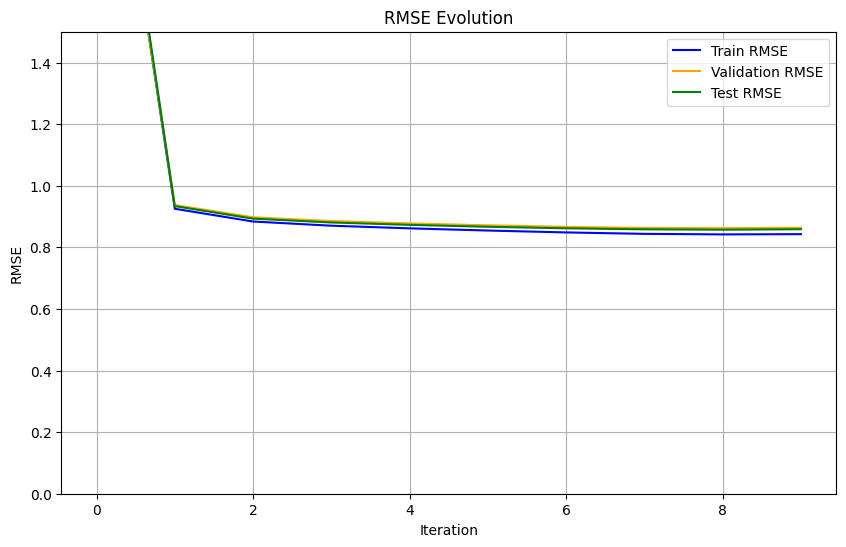

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(plot[0], label='Train RMSE', color='blue')
plt.plot(plot[1], label='Validation RMSE', color='orange')
plt.plot(plot[2], label='Test RMSE', color='green')

plt.ylim(0,1.5)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Evolution')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Call 1
model1 = MFCNN(train_user, train_item, val_user,
               test_user, tokens_U=users_padded_sequences, tokens_M=movie_padded_sequences, vocab_size=10000,
               dropout_rate=0.1, emb_dim=32, user_max_len=10, movie_max_len=100, dimension=500,
               lambda_u=10, lambda_v=40)

num_items 3544
num_user 6040


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_7  │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │       100,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,420 (1.63 MB)

 Trainable params: 427,420 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_8  │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 500)            │       100,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,300 (1.64 MB)

 Trainable params: 430,300 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 2.3346617047064617
val_ loss 2.318174466967554
text_ loss 2.3756863379059427
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 0.8873970946880181
val_ loss 0.9032241757949075
text_ loss 0.9018931899922529
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 0.838634859023454
val_ loss 0.8612558384381646
text_ loss 0.8576797323813333
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 0.8192268543546053
val_ loss 0.847506008054207
text_ loss 0.8436811719106861
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...C

In [61]:
model2 = MFCNN(train_user, train_item, val_user,
               test_user, tokens_U=users_padded_sequences, tokens_M=movie_padded_sequences, vocab_size=10000,
               dropout_rate=0.1, emb_dim=32, user_max_len=10, movie_max_len=100, dimension=500,
               lambda_u=10, lambda_v=60)

num_items 3544
num_user 6040


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_9  │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 500)            │       100,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,420 (1.63 MB)

 Trainable params: 427,420 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_10 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 500)            │       100,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,300 (1.64 MB)

 Trainable params: 430,300 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 2.397257990678937
val_ loss 2.3805119468006404
text_ loss 2.4379447452351553
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 0.901621043485901
val_ loss 0.9150516031610345
text_ loss 0.9134168808441092
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 0.8606056952786327
val_ loss 0.8780210034926118
text_ loss 0.8741973839047513
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...CNN_Movie
Train...CNN module
train loss 0.845100401335132
val_ loss 0.8655821218839747
text_ loss 0.8613600516961079
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 500)
Train...C

In [62]:
model3 = MFCNN(train_user, train_item, val_user,
               test_user, tokens_U=users_padded_sequences, tokens_M=movie_padded_sequences, vocab_size=10000,
               dropout_rate=0.1, emb_dim=32, user_max_len=10, movie_max_len=100, dimension=50,
               lambda_u=10, lambda_v=50)

num_items 3544
num_user 6040


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_11 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50)             │        10,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,970 (1.29 MB)

 Trainable params: 336,970 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_12 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │        10,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,850 (1.30 MB)

 Trainable params: 339,850 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 2.3898126689978434
val_ loss 2.373155438860983
text_ loss 2.430608584014935
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 0.9056170691231175
val_ loss 0.9186276239325011
text_ loss 0.916035747965768
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 0.8593055058989569
val_ loss 0.8766984321070984
text_ loss 0.872731679126339
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 0.839964414792381
val_ loss 0.861301730183527
text_ loss 0.8570594617671046
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie

In [63]:
model4 = MFCNN(train_user, train_item, val_user,
               test_user, tokens_U=users_padded_sequences, tokens_M=movie_padded_sequences, vocab_size=10000,
               dropout_rate=0.1, emb_dim=32, user_max_len=10, movie_max_len=100, dimension=50,
               lambda_u=10, lambda_v=10)

num_items 3544
num_user 6040


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_13 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_13     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 50)             │        10,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,970 (1.29 MB)

 Trainable params: 336,970 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_14 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_14     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 50)             │        10,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,850 (1.30 MB)

 Trainable params: 339,850 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 2.3685748497159467
val_ loss 2.3522996579111397
text_ loss 2.4091968573217195
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 0.8459357214151446
val_ loss 0.8723493566403516
text_ loss 0.8718540816425795
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 0.7486064125244554
val_ loss 0.8099122569415679
text_ loss 0.8078277784277279
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_Movie
Train...CNN module
train loss 0.7001122873946171
val_ loss 0.7904763415165879
text_ loss 0.788827058204204
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 50)
Train...CNN_

In [64]:
model5 = MFCNN(train_user, train_item, val_user,
               test_user, tokens_U=users_padded_sequences, tokens_M=movie_padded_sequences, vocab_size=10000,
               dropout_rate=0.1, emb_dim=32, user_max_len=10, movie_max_len=100, dimension=100,
               lambda_u=100, lambda_v=10)

num_items 3544
num_user 6040


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_15 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_16 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_16     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.6148959733182773
val_ loss 2.599773860058705
text_ loss 2.651862561762202
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9236957902978894
val_ loss 0.9354809109566325
text_ loss 0.9319477589661231
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8842710764771603
val_ loss 0.8977623575916792
text_ loss 0.8931969603881429
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8707235811682021
val_ loss 0.8856200459816276
text_ loss 0.8810371607505377
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...

In [65]:
model6 = MFCNN(train_user, train_item, val_user,
               test_user, tokens_U=users_padded_sequences, tokens_M=movie_padded_sequences, vocab_size=10000,
               dropout_rate=0.1, emb_dim=120, user_max_len=10, movie_max_len=100, dimension=100,
               lambda_u=50, lambda_v=100)

num_items 3544
num_user 6040


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_17 │ (None, 10, 120)        │     1,201,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_17     │ (None, 120)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 200)            │        24,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,245,500 (4.75 MB)

 Trainable params: 1,245,500 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6040


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_18 │ (None, 100, 120)       │     1,212,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_18     │ (None, 120)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 200)            │        24,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256,300 (4.79 MB)

 Trainable params: 1,256,300 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.5870444811501567
val_ loss 2.5705649975916005
text_ loss 2.6266073856035077
iteration N:  2
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9649558919544161
val_ loss 0.9726708402056045
text_ loss 0.9760169085974638
iteration N:  3
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.919110905877004
val_ loss 0.9285556656929002
text_ loss 0.9266810713693896
iteration N:  4
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9150375641175389
val_ loss 0.9247552555345149
text_ loss 0.922481573463952
iteration N:  5
user weight dimesnions (6040,)
tokens_M dimesnions (3544, 100)
U diem (6040, 100)
Train...

## test avec different hyber parameter : 

In [66]:
def process_data(n,ratings,num_movies):
    train, val, test = split_users_data(n)
    
    
    
    train_user = UserMaker(train, n)
    val_user = UserMaker(val, n)
    test_user = UserMaker(test, n)
    print(len(train_user[0]))
    
    
    train,val,test  = split_movies_data(ratings)
    train_item = MovieMaker(train,len(moviesWP))
    val_item = MovieMaker(val,len(moviesWP))
    test_item = MovieMaker(test,len(moviesWP))
    
    print(len(train_item[0]))
    
    
    
    
    return train_user, val_user, test_user,train_item,val_item,test_item

In [67]:
user_counts = [1000,2000, 3000, 4000, 5000, 6000]

for n in user_counts:
    ratings  = ratings_df[ratings_df["UserID"] < n]
    train_user, val_user, test_user,train_item,val_item,test_item = process_data(n,ratings,len(moviesWP))
    descrpiton  = users_df[users_df["UserID"]< n]["user_description"]

    users_padded_sequences = tokenize_and_pad_sequences(descrpiton,n,vocab_size=10000,max_seq_len=10)

    print(len(train_item[0]))
    
    
    
    print(f"Processed data for {n} users")
    
    MFCNN(train_user,train_item,val_user,
            test_user,tokens_U = users_padded_sequences,tokens_M=movie_padded_sequences,vocab_size=10000,
              dropout_rate=0.1,emb_dim=32,user_max_len=10,movie_max_len=100,dimension=100,
              lambda_u=100,lambda_v=10)
    
    print("======================================")

1000
3544
3544
Processed data for 1000 users
num_items 3544
num_user 1000


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_19 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_19     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  1000


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_20 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_20     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (1000,)
tokens_M dimesnions (3544, 100)
U diem (1000, 100)
Train...CNN_Movie
Train...CNN module
train loss 3.219203379833639
val_ loss 3.214552738431339
text_ loss 3.24236481593912
iteration N:  2
user weight dimesnions (1000,)
tokens_M dimesnions (3544, 100)
U diem (1000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9840352034229682
val_ loss 0.9959871880969491
text_ loss 1.0053936203780953
iteration N:  3
user weight dimesnions (1000,)
tokens_M dimesnions (3544, 100)
U diem (1000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9154426924582998
val_ loss 0.9308401560831819
text_ loss 0.9291455341143356
iteration N:  4
user weight dimesnions (1000,)
tokens_M dimesnions (3544, 100)
U diem (1000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9078481099980645
val_ loss 0.9235936779166997
text_ loss 0.9205712560091669
iteration N:  5
user weight dimesnions (1000,)
tokens_M dimesnions (3544, 100)
U diem (1000, 100)
Train...CN

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_21 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_21     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  2000


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_22 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_22     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (2000,)
tokens_M dimesnions (3544, 100)
U diem (2000, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.795746170497858
val_ loss 2.7873382550669286
text_ loss 2.8355986109744973
iteration N:  2
user weight dimesnions (2000,)
tokens_M dimesnions (3544, 100)
U diem (2000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9304918875155653
val_ loss 0.9398272747093467
text_ loss 0.9455657239168441
iteration N:  3
user weight dimesnions (2000,)
tokens_M dimesnions (3544, 100)
U diem (2000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8956128675058994
val_ loss 0.9048483481527151
text_ loss 0.9082736065500988
iteration N:  4
user weight dimesnions (2000,)
tokens_M dimesnions (3544, 100)
U diem (2000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8901714866423566
val_ loss 0.8994128420756239
text_ loss 0.9030576752058321
iteration N:  5
user weight dimesnions (2000,)
tokens_M dimesnions (3544, 100)
U diem (2000, 100)
Train..

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_23 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_23     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  3000


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_24 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_24     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (3000,)
tokens_M dimesnions (3544, 100)
U diem (3000, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.703618876118897
val_ loss 2.6876463226367515
text_ loss 2.736273462291419
iteration N:  2
user weight dimesnions (3000,)
tokens_M dimesnions (3544, 100)
U diem (3000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9349428677816808
val_ loss 0.9407260486185349
text_ loss 0.944346721588471
iteration N:  3
user weight dimesnions (3000,)
tokens_M dimesnions (3544, 100)
U diem (3000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8951889784932828
val_ loss 0.9026301605867838
text_ loss 0.9040559978652187
iteration N:  4
user weight dimesnions (3000,)
tokens_M dimesnions (3544, 100)
U diem (3000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8858532514387205
val_ loss 0.8942420043214728
text_ loss 0.8954355426471522
iteration N:  5
user weight dimesnions (3000,)
tokens_M dimesnions (3544, 100)
U diem (3000, 100)
Train...C

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_25 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_25     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  4000


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_26 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_26     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (4000,)
tokens_M dimesnions (3544, 100)
U diem (4000, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.6081564840228255
val_ loss 2.590299895973331
text_ loss 2.6456878540740894
iteration N:  2
user weight dimesnions (4000,)
tokens_M dimesnions (3544, 100)
U diem (4000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9264229999887662
val_ loss 0.9310117514727106
text_ loss 0.9352328775181682
iteration N:  3
user weight dimesnions (4000,)
tokens_M dimesnions (3544, 100)
U diem (4000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.891475628776643
val_ loss 0.8978109071894639
text_ loss 0.9003021498806071
iteration N:  4
user weight dimesnions (4000,)
tokens_M dimesnions (3544, 100)
U diem (4000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8813102829985421
val_ loss 0.8887463610232328
text_ loss 0.8917750509380039
iteration N:  5
user weight dimesnions (4000,)
tokens_M dimesnions (3544, 100)
U diem (4000, 100)
Train...

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_27 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_27     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  5000


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_28 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_28     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (5000,)
tokens_M dimesnions (3544, 100)
U diem (5000, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.5855403642540997
val_ loss 2.5679670982657985
text_ loss 2.6269540759127086
iteration N:  2
user weight dimesnions (5000,)
tokens_M dimesnions (3544, 100)
U diem (5000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9204503834808482
val_ loss 0.9272361048504161
text_ loss 0.9311618086777671
iteration N:  3
user weight dimesnions (5000,)
tokens_M dimesnions (3544, 100)
U diem (5000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8860435091752016
val_ loss 0.8941601132989311
text_ loss 0.8960596094944214
iteration N:  4
user weight dimesnions (5000,)
tokens_M dimesnions (3544, 100)
U diem (5000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8732269272512507
val_ loss 0.8821087173684211
text_ loss 0.8845787330438398
iteration N:  5
user weight dimesnions (5000,)
tokens_M dimesnions (3544, 100)
U diem (5000, 100)
Train.

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_29 │ (None, 10, 32)         │       320,320 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_29     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,020 (1.32 MB)

 Trainable params: 347,020 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

tokens_U size  6000


Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_30 │ (None, 100, 32)        │       323,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_30     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 200)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,900 (1.33 MB)

 Trainable params: 349,900 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

iteration N:  1
user weight dimesnions (6000,)
tokens_M dimesnions (3544, 100)
U diem (6000, 100)
Train...CNN_Movie
Train...CNN module
train loss 2.624495137807943
val_ loss 2.6038190196401994
text_ loss 2.6602173445786144
iteration N:  2
user weight dimesnions (6000,)
tokens_M dimesnions (3544, 100)
U diem (6000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.9234832912113713
val_ loss 0.9328245476109144
text_ loss 0.9333558306047687
iteration N:  3
user weight dimesnions (6000,)
tokens_M dimesnions (3544, 100)
U diem (6000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8835785060475083
val_ loss 0.8948032218341357
text_ loss 0.8936298314628051
iteration N:  4
user weight dimesnions (6000,)
tokens_M dimesnions (3544, 100)
U diem (6000, 100)
Train...CNN_Movie
Train...CNN module
train loss 0.8703193655134891
val_ loss 0.882402878385151
text_ loss 0.8819802536560767
iteration N:  5
user weight dimesnions (6000,)
tokens_M dimesnions (3544, 100)
U diem (6000, 100)
Train...

In [68]:
users_padded_sequences = tokenize_and_pad_sequences(users_df['user_description'],1000,vocab_size=10000,max_seq_len=10)


In [69]:
users_padded_sequences.shape

(6040, 10)

## test

In [70]:
n=2000;
train, val, test = split_users_data(n)
    
    
train_user = UserMaker(train, n)
val_user = UserMaker(val, n)
test_user = UserMaker(test, n)
print(len(train_user[0]))
    
    
    

2000


In [71]:
train_user[0][0]

array([   0,   47,  248,  500,  504,  558,  565,  577,  617,  680,  711,
        813,  818,  837,  913,  918,  919,  925,  978, 1053, 1062, 1140,
       1357, 1504, 1584, 1649, 1760, 1770, 2017, 2060, 2074, 2385, 2390,
       2456, 2484, 2490, 2497, 2603, 2774, 2783, 3044])

In [72]:
ratings  = ratings_df[ratings_df["UserID"] < 2000]
train,val,test  = split_movies_data(ratings)
train_item = MovieMaker(train,len(moviesWP))
val_item = MovieMaker(val,len(moviesWP))
test_item = MovieMaker(test,len(moviesWP))
    
print(len(train_item[0]))

3544


In [73]:
train_item[0][2000]

array([1469])

## predictiion on train data 

In [75]:
import pandas as pd

user = 0
Ratings =  train_user[1][user]
MoviesId = train_user[0][user]


# Create an empty DataFrame to store the movie ratings
movie_ratings_df = pd.DataFrame(columns=['MovieID', 'OriginalRating', 'PredictedRating'], dtype=float)
user =2
# Populate the DataFrame with movie ratings
for i in range(len(Ratings)):
    movieId = MoviesId[i]
    originalRating = Ratings[i]
    predictedRating = model[user][movieId]
    movie_ratings_df = pd.concat([movie_ratings_df, pd.DataFrame({'MovieID': [movieId], 'OriginalRating': [originalRating], 'PredictedRating': [predictedRating]}, dtype=float)], ignore_index=True)

# Sort the DataFrame by predicted ratings
movie_ratings_df = movie_ratings_df.sort_values(by='PredictedRating', ascending=False)

# Merge with moviesWP DataFrame to get movie titles
merged_df = pd.merge(movie_ratings_df, moviesWP, on='MovieID')

# Print the top 10 movies with specified columns
top_10_movies = merged_df
top_10_movies[['title','OriginalRating', 'PredictedRating']].head(100)


,title,OriginalRating,PredictedRating
0,Schindler's List (1993),5.0,4.541038
1,"Close Shave, A (1995)",3.0,4.462116
2,"Sixth Sense, The (1999)",4.0,4.460772
3,Star Wars: Episode IV - A New Hope (1977),4.0,4.417551
4,To Kill a Mockingbird (1962),4.0,4.400616
5,Saving Private Ryan (1998),5.0,4.328362
6,"Princess Bride, The (1987)",3.0,4.326606
7,"Christmas Story, A (1983)",5.0,4.267309
8,Toy Story 2 (1999),4.0,4.227661
9,"Wizard of Oz, The (1939)",4.0,4.226501
